# Iris Dataset

The goal is the classify the various iris observations into their correct labels. I am trying to use this  Notebook as a way to learn, but also teach about classification, KNN and KFold cross validation.  

## Getting the Data

For our Iris dataset we are using the data provided by UCI Machine Learning Repository. In order to make the data usable we read it into a Pandas dataframe.  We then split our data into the dependent variable y (the type of iris) and the independent variables X (the measurements).  We are calling .values  in order to make X and y NumPy ndarrays instead of leaving them as a dataframe in the case of X, and a series in the case of y. Ndarrays are significantly faster to work with than both Pandas objects as both a series and a dataframe require more overhead for things such as data type checking.  Note that y would have been a series because it is a one-dimensional object whereas X would have been a dataframe because it is two-dimensional. 

In [1]:
import pandas as pd
import numpy as np

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(url)

X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

# TODO: talk about train test split and parameters, KNN and parameters, accuracy_score and how it varies based on our split,  touch on matplotlib
  

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
k_range = list(range(1,26))
accuracy_scores = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train,y_train)
  knn_pred = knn.predict(X_test)
  accuracy_scores.append(accuracy_score(y_test,knn_pred))

# TODO: explain graph generically (results won't be reproduced)

Text(0.5, 1.0, 'Accuracy for each Value of K in KNN')

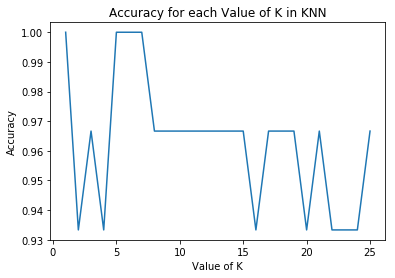

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_range,accuracy_scores)
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.title('Accuracy for each Value of K in KNN')

# TODO: talk about confusion matrix and metrics we can derive from them,

In [4]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
knn_cm = confusion_matrix(y_test,knn_pred)

#TODO: talking about benefits of Kfold cross validation as well as drawbacks, talk about hyperparamters

In [5]:
from sklearn.model_selection import cross_val_score
knn_cross = KNeighborsClassifier(n_neighbors = 5)
cross_val_scores = cross_val_score(knn_cross,X,y, cv = 10, scoring='accuracy')

#TODO: explain graph

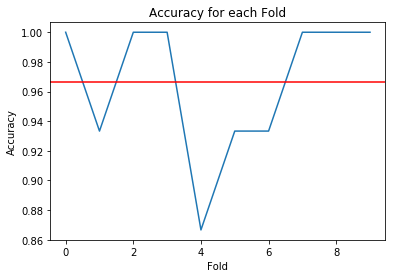

In [6]:
plt.plot(list(range(10)),cross_val_scores)
plt.axhline(y = cross_val_scores.mean(),color = 'red')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy for each Fold')
plt.show()

#TODO: explain using Kfold cross validation for tuning hyperparams

In [7]:
k_range = list(range(1,31))
k_scores = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train,y_train)
  cross_val_scores = cross_val_score(knn,X,y, cv = 10, scoring='accuracy')
  k_scores.append(cross_val_scores.mean())

#TODO: Explain graph

Text(0.5, 1.0, 'Cross Validated Accuracy for each Value of K')

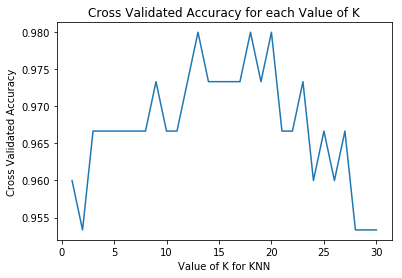

In [8]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross Validated Accuracy')
plt.title('Cross Validated Accuracy for each Value of K')

#TODO: explain why we picked 20 for KNN and explain our expected accuracy

In [9]:
knn = KNeighborsClassifier(n_neighbors=20)
best_knn_score = cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()

### Acknowledgements

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.